In [ ]:
import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam


In [ ]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

config = Config()
seed_everything(config.seed)

In [ ]:
df_ptbdb = pd.read_csv('/Users/adityadwivedi/Downloads/ECG/ptbdb_abnormal.csv')
df_mitbih = pd.read_csv('/Users/adityadwivedi/Downloads/ECG/mitbih_train.csv')
df_ptbdb.head()

9.322328567504882812e-01  8.696785569190979004e-01  \
0                  1.000000                  0.606941   
1                  1.000000                  0.951613   
2                  0.977819                  0.899261   
3                  0.935618                  0.801661   
4                  0.925265                  0.433352   

   8.861859440803527832e-01  9.296264052391052246e-01  \
0                  0.384181                  0.254237   
1                  0.923963                  0.853303   
2                  0.230129                  0.032348   
3                  0.805815                  1.000000   
4                  0.073620                  0.079197   

   9.087749719619750977e-01  9.339704513549804688e-01  \
0                  0.223567                  0.276836   
1                  0.791859                  0.734255   
2                  0.142329                  0.223660   
3                  0.722741                  0.480789   
4                  0.136643                  0.182934   

   8.010425567626953125e-01  7.497828006744384766e-01  \
0                  0.253430                  0.184826   
1                  0.672043                  0.685100   
2                  0.328096                  0.367837   
3                  0.454829                  0.319834   
4                  0.182934                  0.182376   

   6.872285008430480957e-01  6.350998878479003906e-01  ...  \
0                  0.153349                  0.121872  ...   
1                  0.670507                  0.667435  ...   
2                  0.381701                  0.389094  ...   
3                  0.266874                  0.308411  ...   
4                  0.196877                  0.203569  ...   

   0.000000000000000000e+00.117  0.000000000000000000e+00.118  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   0.000000000000000000e+00.119  0.000000000000000000e+00.120  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   0.000000000000000000e+00.121  0.000000000000000000e+00.122  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   0.000000000000000000e+00.123  0.000000000000000000e+00.124  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   0.000000000000000000e+00.125  1.000000000000000000e+00.1  
0                           0.0                         1.0  
1                           0.0                         1.0  
2                           0.0                         1.0  
3                           0.0                         1.0  
4                           0.0                         1.0  

[5 rows x 188 columns]

In [ ]:
df_mitbih_train = pd.read_csv('/Users/adityadwivedi/Downloads/ECG/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv( '/Users/adityadwivedi/Downloads/ECG/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Index: 109446 entries, 0 to 21891
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 158.7+ MB
None


In [ ]:
df_mitbih.to_csv('data.csv', index=False)
config.csv_path = 'data.csv'

In [ ]:
df_mitbih['label'].value_counts()

label
Normal                               90589
Fusion of paced and normal            8039
Premature ventricular contraction     7236
Artial Premature                      2779
Fusion of ventricular and normal       803
Name: count, dtype: int64

/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/ipykernel_20640/4048187147.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/ipykernel_20640/4048187147.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15);


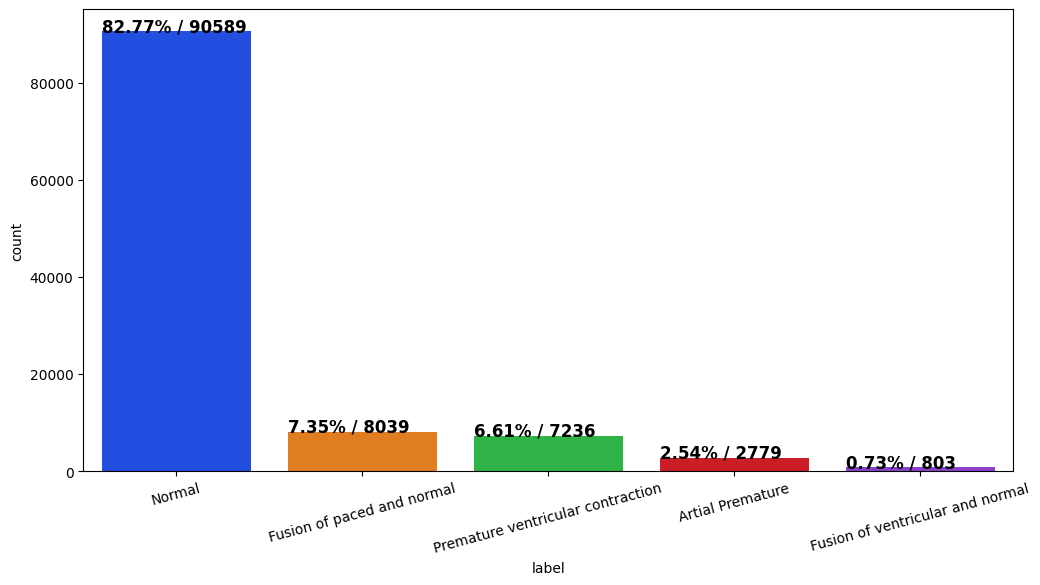

In [ ]:
percentages = [count / df_mitbih.shape[0] * 100 for count in df_mitbih['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=df_mitbih['label'],
    ax=ax,
    palette="bright",
    order=df_mitbih['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    df_mitbih['label'].value_counts(sort=True).values,
    ax.patches):

    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')

plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [ ]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

def get_dataloader(label_name, batch_size):
    df = pd.read_csv(config.csv_path)
    df = df.loc[df['label'] == label_name]
    df.reset_index(drop=True, inplace=True)
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    return dataloader


dataloader = get_dataloader(label_name='Artial Premature', batch_size=96)

print(len(dataloader))
x,y = next(iter(dataloader))
x.shape, y.shape

29


/var/folders/7d/vzx818195gndjk3505n2d51h0000gn/T/ipykernel_20640/3944258185.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  signal = torch.FloatTensor([signal.values])


(torch.Size([96, 1, 187]), torch.Size([96]))

Epoch: 0 | Loss_D: -0.00012599583715200424 | Loss_G: 0.011071140877902508 | Time: 23:21:21


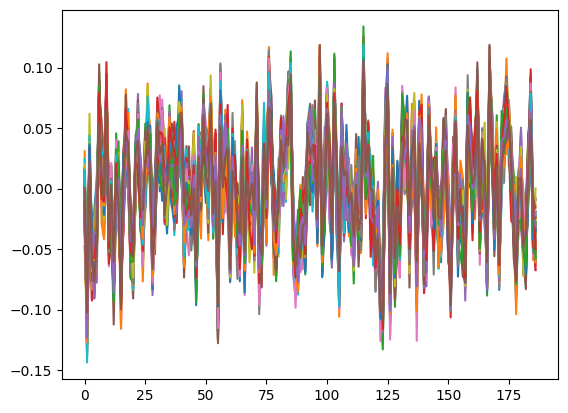

Epoch: 100 | Loss_D: -1.0641307830810547 | Loss_G: 0.0192844420671463 | Time: 23:21:58


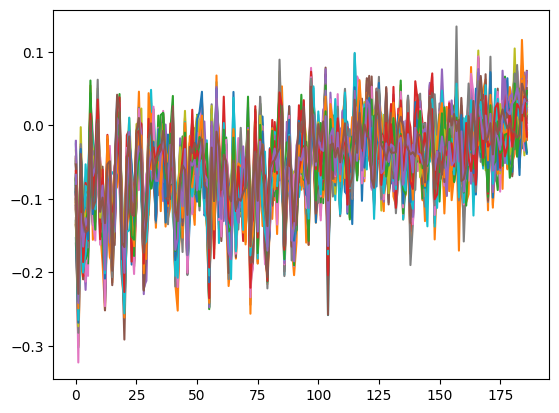

Epoch: 200 | Loss_D: -1.084003210067749 | Loss_G: 0.013148014433681965 | Time: 23:22:38


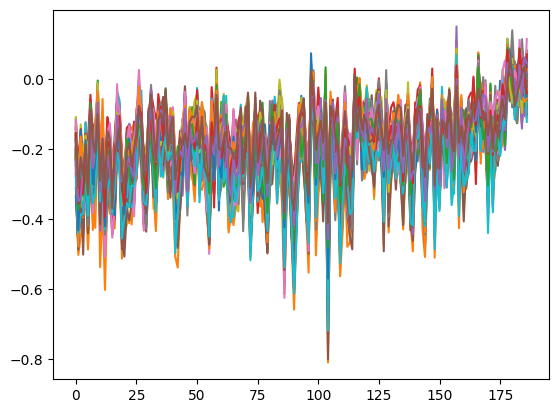

Epoch: 300 | Loss_D: -1.082640528678894 | Loss_G: 0.01123746857047081 | Time: 23:23:14


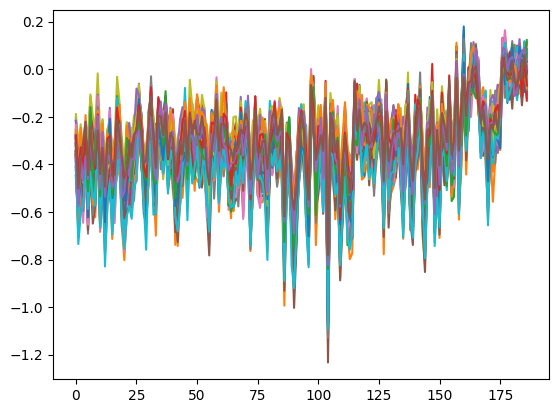

Epoch: 400 | Loss_D: -1.0905249118804932 | Loss_G: 0.011148553341627121 | Time: 23:23:53


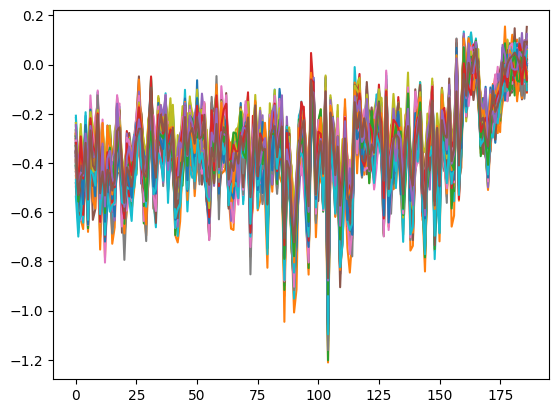

Epoch: 500 | Loss_D: -1.069758415222168 | Loss_G: 0.011140813119709492 | Time: 23:24:40


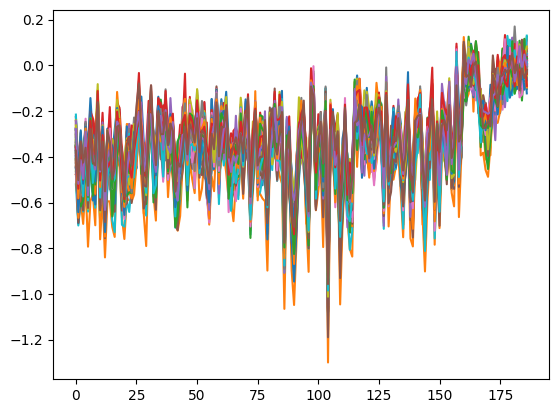

Epoch: 600 | Loss_D: -1.0823241472244263 | Loss_G: 0.011102117598056793 | Time: 23:25:26


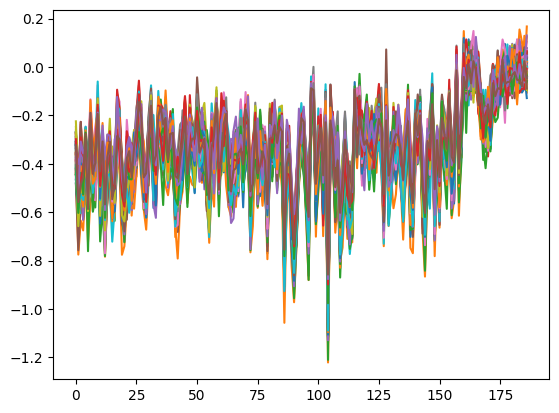

Epoch: 700 | Loss_D: -1.0919773578643799 | Loss_G: 0.011113833636045456 | Time: 23:26:12


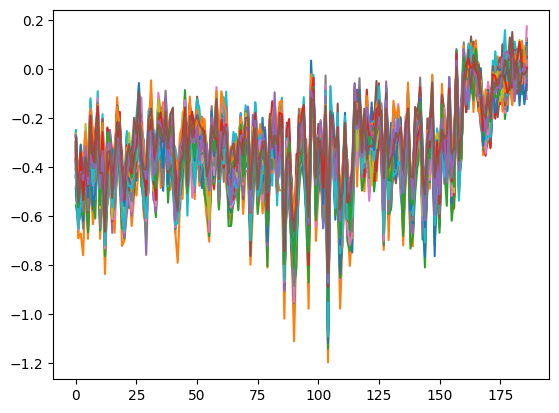

Epoch: 800 | Loss_D: -1.081278681755066 | Loss_G: 0.011115219444036484 | Time: 23:26:50


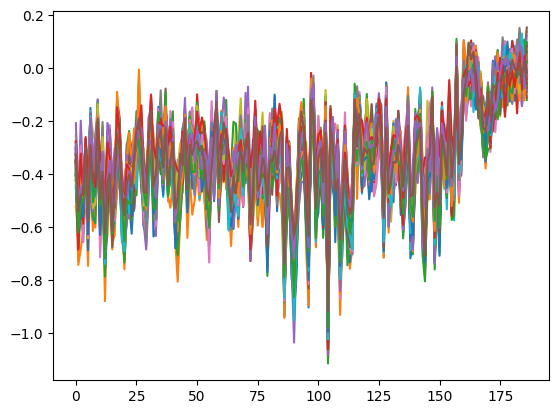

Epoch: 900 | Loss_D: -1.0833970308303833 | Loss_G: 0.011112154461443424 | Time: 23:27:32


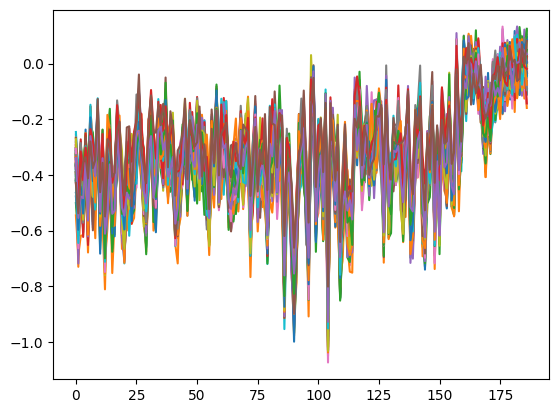

Epoch: 1000 | Loss_D: -1.0776890516281128 | Loss_G: 0.011117428541183472 | Time: 23:28:13


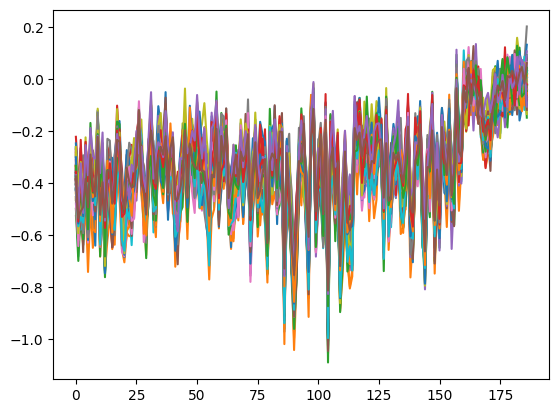

Epoch: 1100 | Loss_D: -1.0738126039505005 | Loss_G: 0.011091022752225399 | Time: 23:28:52


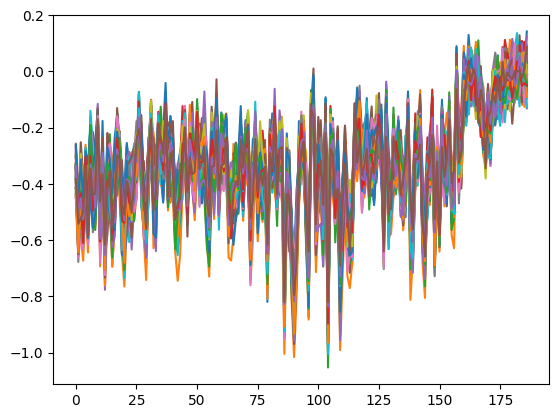

Epoch: 1200 | Loss_D: -1.0814485549926758 | Loss_G: 0.011128872632980347 | Time: 23:29:34


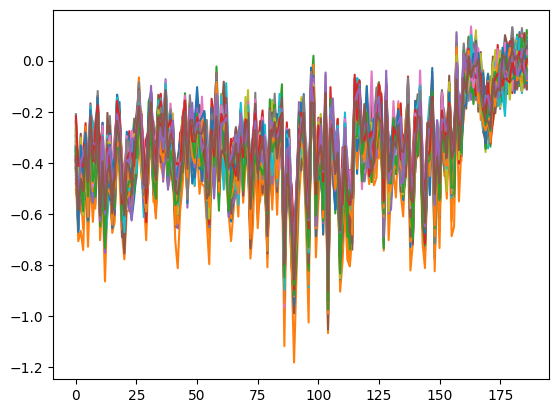

Epoch: 1300 | Loss_D: -1.089829444885254 | Loss_G: 0.011099051684141159 | Time: 23:30:16


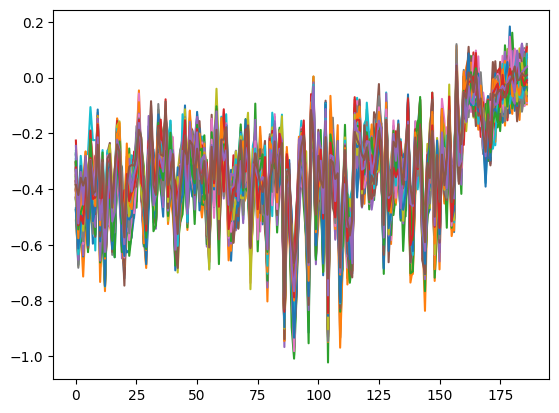

Epoch: 1400 | Loss_D: -1.0703173875808716 | Loss_G: 0.011127420701086521 | Time: 23:31:01


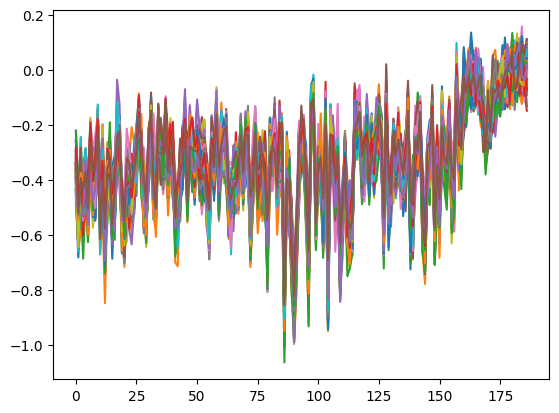

Epoch: 1500 | Loss_D: -1.0705333948135376 | Loss_G: 0.011059582233428955 | Time: 23:31:40


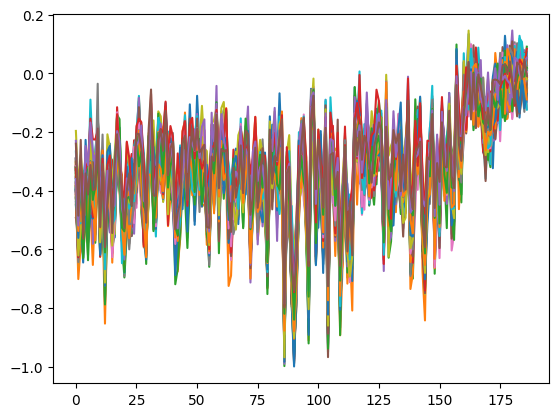

Epoch: 1600 | Loss_D: -1.0709524154663086 | Loss_G: 0.011136885732412338 | Time: 23:32:22


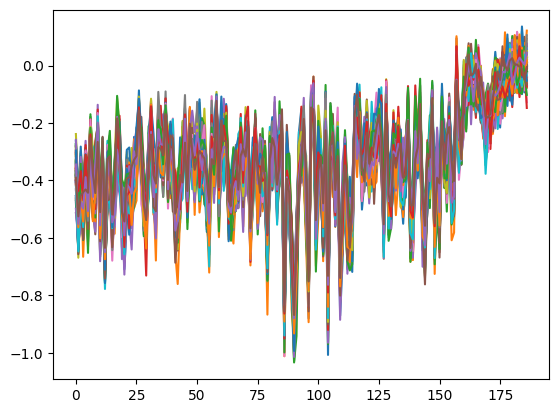

Epoch: 1700 | Loss_D: -1.088871955871582 | Loss_G: 0.01113979984074831 | Time: 23:32:59


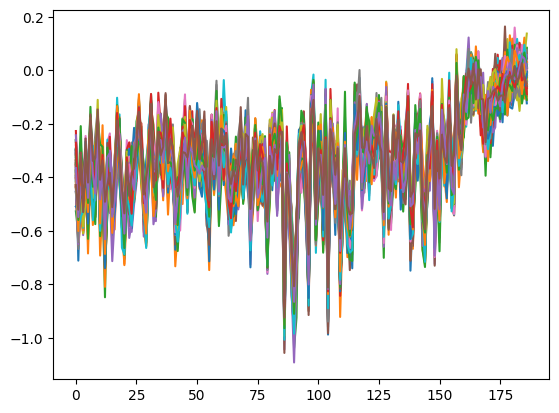

Epoch: 1800 | Loss_D: -1.0553332567214966 | Loss_G: 0.011096923612058163 | Time: 23:33:36


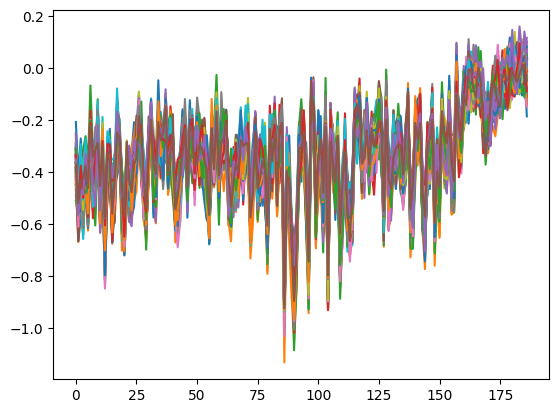

Epoch: 1900 | Loss_D: -1.0719850063323975 | Loss_G: 0.011124949902296066 | Time: 23:34:15


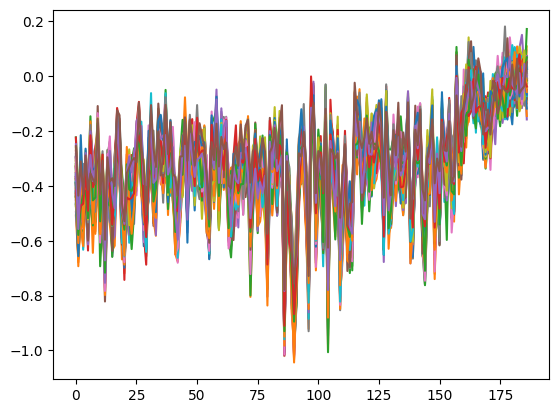

Epoch: 2000 | Loss_D: -1.075502872467041 | Loss_G: 0.011113442480564117 | Time: 23:34:48


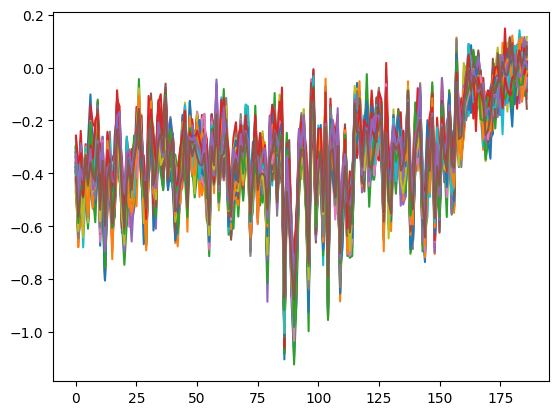

Epoch: 2100 | Loss_D: -1.0918304920196533 | Loss_G: 0.011132077313959599 | Time: 23:35:21


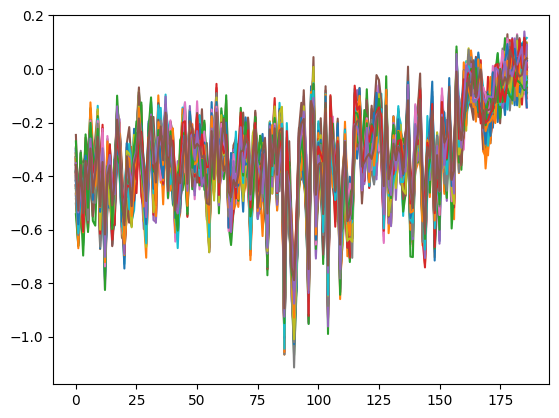

Epoch: 2200 | Loss_D: -1.0800553560256958 | Loss_G: 0.011135440319776535 | Time: 23:35:54


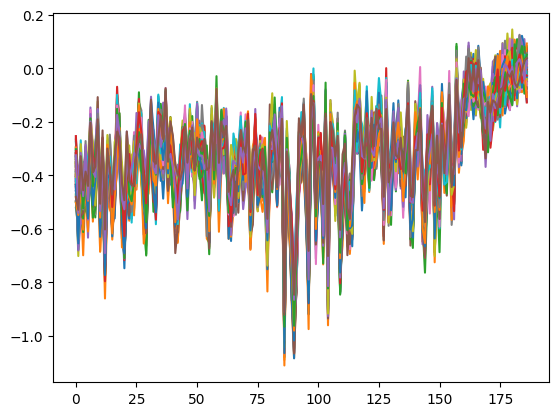

Epoch: 2300 | Loss_D: -1.081742525100708 | Loss_G: 0.01107009220868349 | Time: 23:36:25


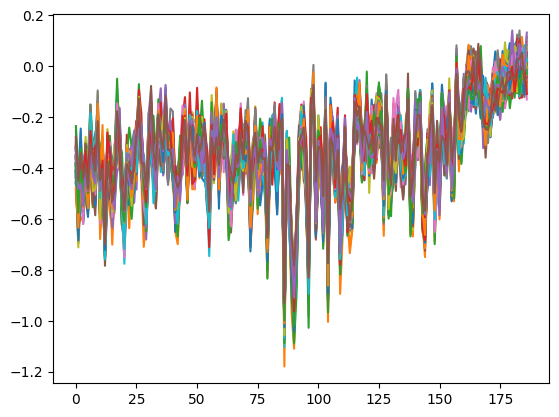

Epoch: 2400 | Loss_D: -1.0873476266860962 | Loss_G: 0.011079122312366962 | Time: 23:36:56


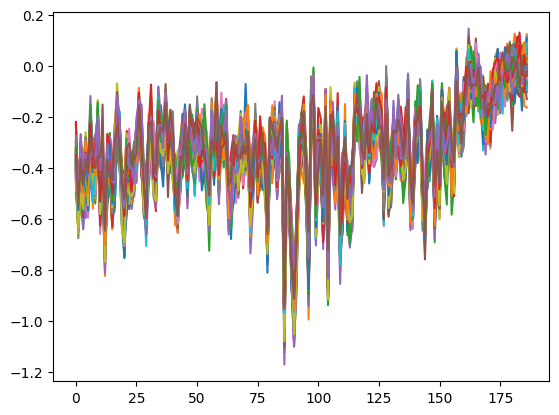

Epoch: 2500 | Loss_D: -1.0744844675064087 | Loss_G: 0.011076654307544231 | Time: 23:37:28


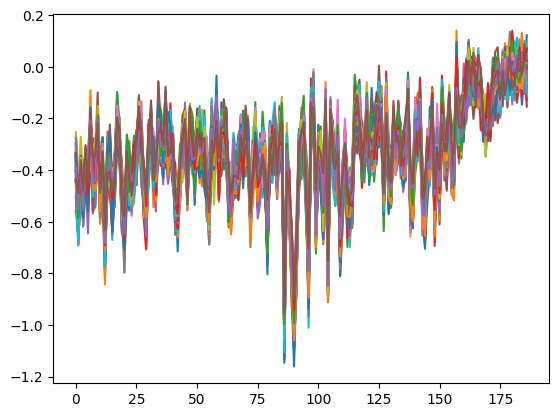

Epoch: 2600 | Loss_D: -1.0700165033340454 | Loss_G: 0.011077488772571087 | Time: 23:38:02


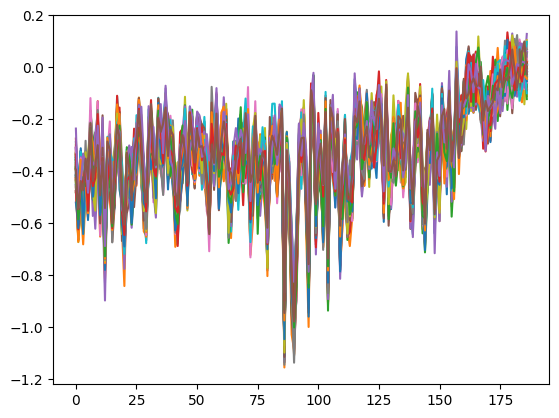

Epoch: 2700 | Loss_D: -1.0720990896224976 | Loss_G: 0.011064444668591022 | Time: 23:38:33


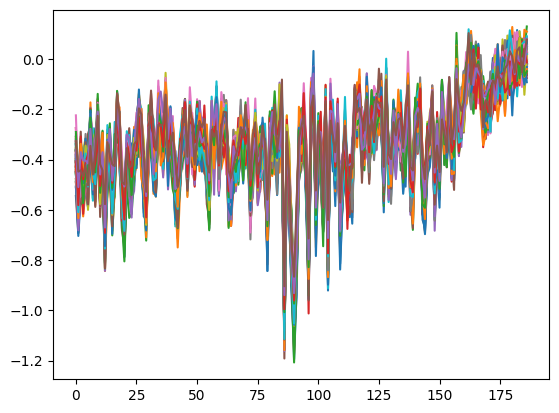

Epoch: 2800 | Loss_D: -1.079370379447937 | Loss_G: 0.011077147908508778 | Time: 23:39:05


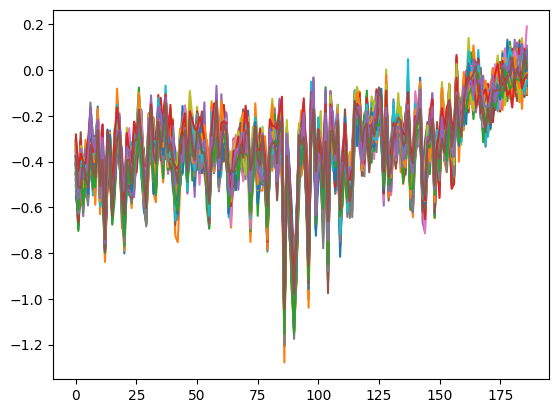

Epoch: 2900 | Loss_D: -1.0900096893310547 | Loss_G: 0.011060674674808979 | Time: 23:39:37


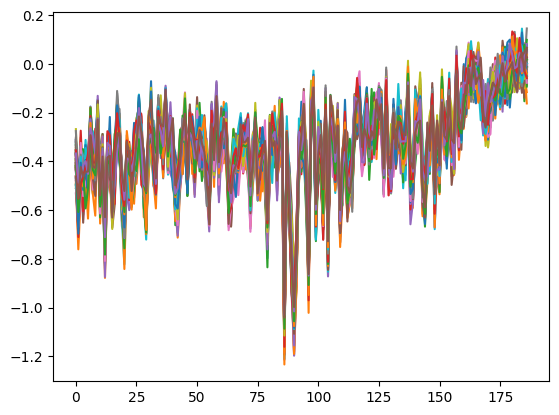

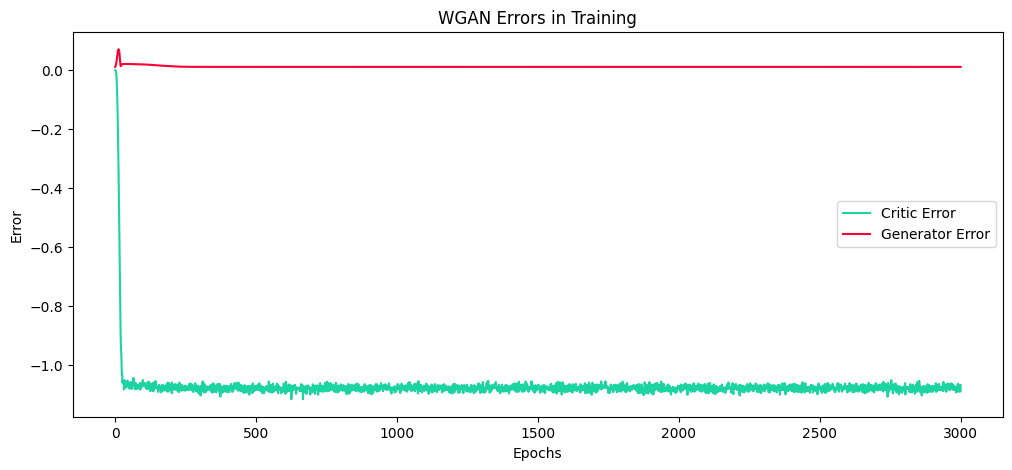

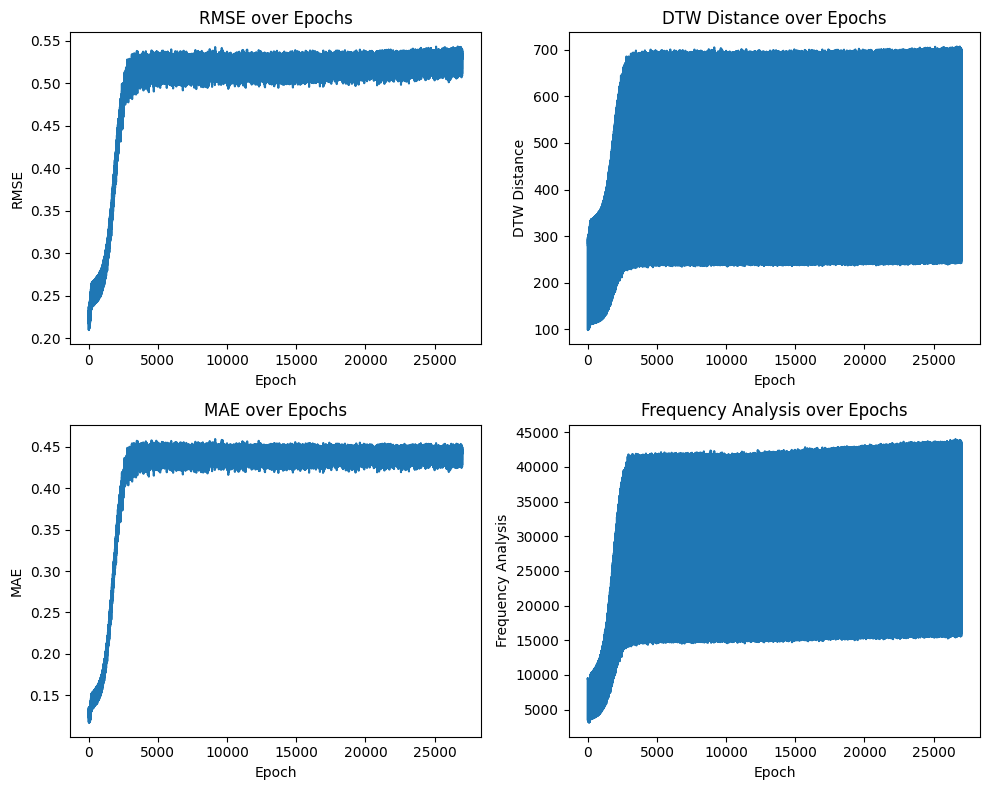

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# Add evaluation functions
def compute_rmse(pred, true):
    return np.sqrt(((pred - true) ** 2).mean())

def compute_dtw(pred, true):
    distance, _ = fastdtw(pred, true, dist=euclidean)
    return distance

def compute_mae(pred, true):
    return np.abs(pred - true).mean()

def compute_frequency_analysis(signal):
    return np.sum(np.abs(np.fft.fft(signal)))  # Basic frequency domain analysis

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 187)
        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=128,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )

    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1,256)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = self.fc3(x)
        return x.unsqueeze(1)

class Critic(nn.Module):  # Changed from Discriminator to Critic
    def __init__(self):
        super(Critic, self).__init__()

        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=256,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # No sigmoid, output a real-valued score

    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1, 512)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = self.fc3(x)
        return x  # Real-valued score without sigmoid

class WGANTrainer:
    def __init__(self, generator, critic, batch_size, num_epochs, label, clip_value=0.01):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.netG = generator.to(self.device)
        self.netD = critic.to(self.device)

        self.optimizerD = optim.RMSprop(self.netD.parameters(), lr=0.00005)
        self.optimizerG = optim.Adam(self.netG.parameters(), lr=0.00005, betas=(0.5, 0.999))

        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.dataloader = get_dataloader(label_name=label, batch_size=self.batch_size)
        self.fixed_noise = torch.randn(self.batch_size, 1, 187, device=self.device)

        self.clip_value = clip_value
        self.g_errors = []
        self.d_errors = []
        self.rmse_metrics = []
        self.dtw_metrics = []
        self.mae_metrics = []
        self.freq_metrics = []

    def _one_epoch(self):
        for i, data in enumerate(self.dataloader, 0):
            real_data = data[0].to(self.device)
            batch_size = real_data.size(0)

            # Train the Critic (Discriminator)
            self.netD.zero_grad()
            label = torch.full((batch_size,), 1, dtype=real_data.dtype, device=self.device)

            # Real data
            output_real = self.netD(real_data)
            d_loss_real = output_real.mean()
            d_loss_real.backward()

            # Fake data
            noise = torch.randn(batch_size, 1, 187, device=self.device)
            fake_data = self.netG(noise)
            output_fake = self.netD(fake_data.detach())
            d_loss_fake = output_fake.mean()
            d_loss_fake.backward()

            # Gradient penalty (WGAN-GP only, optional but recommended)
            d_loss = d_loss_real - d_loss_fake
            self.optimizerD.step()

            # Weight clipping for Critic
            for p in self.netD.parameters():
                p.data.clamp_(-self.clip_value, self.clip_value)

            # Train the Generator every 5 iterations of Critic
            if i % 5 == 0:
                self.netG.zero_grad()
                output_fake = self.netD(fake_data)
                g_loss = -output_fake.mean()  # Generator loss
                g_loss.backward()
                self.optimizerG.step()

            # Compute evaluation metrics for the generated data
            fake_ecg = fake_data.detach().cpu().squeeze(1).numpy()
            real_ecg = real_data.cpu().squeeze(1).numpy()

            rmse = compute_rmse(fake_ecg, real_ecg)
            dtw = compute_dtw(fake_ecg, real_ecg)
            mae = compute_mae(fake_ecg, real_ecg)
            freq = compute_frequency_analysis(fake_ecg)

            self.rmse_metrics.append(rmse)
            self.dtw_metrics.append(dtw)
            self.mae_metrics.append(mae)
            self.freq_metrics.append(freq)

        return d_loss.item(), g_loss.item()

    def run(self):
        for epoch in range(self.num_epochs):
            errD_, errG_ = self._one_epoch()
            self.d_errors.append(errD_)
            self.g_errors.append(errG_)

            if epoch % 100 == 0:
                print(f"Epoch: {epoch} | Loss_D: {errD_} | Loss_G: {errG_} | Time: {time.strftime('%H:%M:%S')}")

                # Optionally visualize fake ECG signals
                fake_ecg = self.netG(self.fixed_noise).detach().cpu().squeeze(1).numpy()
                plt.plot(fake_ecg.transpose())
                plt.show()

        # Plot errors and metrics
        self._plot_errors()
        self._plot_metrics()

        # Save model
        torch.save(self.netG.state_dict(), f"generator_wgan.pth")
        torch.save(self.netD.state_dict(), f"critic_wgan.pth")

    def _plot_errors(self):
        plt.figure(figsize=(12, 5))
        plt.title("WGAN Errors in Training")
        plt.plot(self.d_errors, label='Critic Error', c='#1CD3A2')
        plt.plot(self.g_errors, label='Generator Error', c='#FF0033')
        plt.xlabel("Epochs")
        plt.ylabel('Error')
        plt.legend()
        plt.show()

    def _plot_metrics(self):
        epochs = range(self.num_epochs)
        plt.figure(figsize=(10, 8))

        plt.subplot(2, 2, 1)
        plt.plot(self.rmse_metrics, label='RMSE')
        plt.title('RMSE over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')

        plt.subplot(2, 2, 2)
        plt.plot(self.dtw_metrics, label='DTW Distance')
        plt.title('DTW Distance over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('DTW Distance')

        plt.subplot(2, 2, 3)
        plt.plot(self.mae_metrics, label='MAE')
        plt.title('MAE over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')

        plt.subplot(2, 2, 4)
        plt.plot(self.freq_metrics, label='Frequency Analysis')
        plt.title('Frequency Analysis over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Frequency Analysis')

        plt.tight_layout()
        plt.show()

    def _print_final_metrics(self):
        print("Final Metrics:")
        print(f"Final RMSE: {self.rmse_metrics[-1]}")
        print(f"Final DTW Distance: {self.dtw_metrics[-1]}")
        print(f"Final MAE: {self.mae_metrics[-1]}")
        print(f"Final Frequency Analysis: {self.freq_metrics[-1]}")

# Create and train WGAN
g = Generator()
d = Critic()

trainer = WGANTrainer(
    generator=g,
    critic=d,
    batch_size=96,
    num_epochs=3000,
    label='Fusion of ventricular and normal'
)
trainer.run()


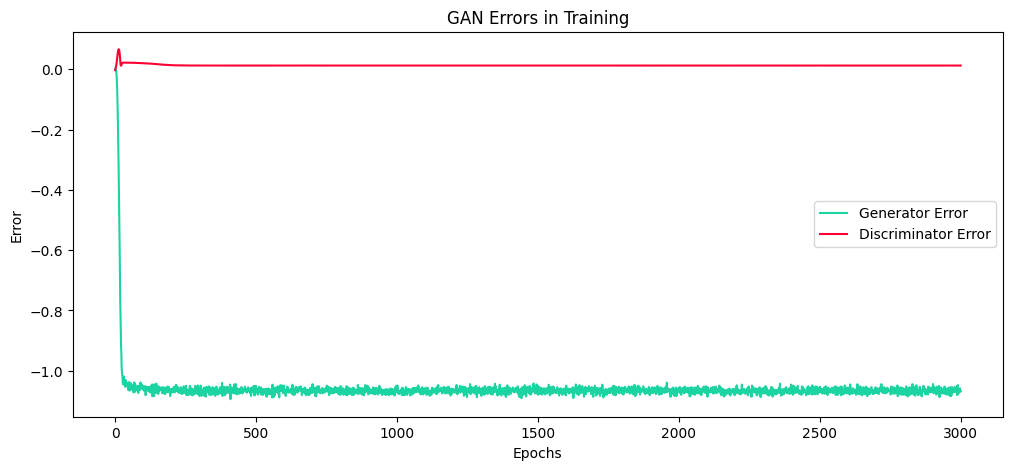

In [ ]:
plt.figure(figsize=(12, 5))
plt.title("GAN Errors in Training")
plt.plot(trainer.d_errors, label='Generator Error', c='#1CD3A2')
plt.plot(trainer.g_errors, label='Discriminator Error', c='#FF0033')
plt.xlabel("Epochs")
plt.ylabel('Error')
_ = plt.legend()
plt.savefig('Gan_Losses.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('Gan_Losses.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [ ]:
# Update _plot_metrics to show each metric in a separate plot
def _plot_metrics(self):
    # RMSE plot
    plt.figure(figsize=(12, 5))
    plt.title("RMSE Over Epochs")
    plt.plot(self.rmse_metrics, label='RMSE', c='#FF5733')
    plt.xlabel("Epochs")
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

    # DTW plot
    plt.figure(figsize=(12, 5))
    plt.title("DTW Distance Over Epochs")
    plt.plot(self.dtw_metrics, label='DTW Distance', c='#1C99FF')
    plt.xlabel("Epochs")
    plt.ylabel('DTW Distance')
    plt.legend()
    plt.show()

    # MAE plot
    plt.figure(figsize=(12, 5))
    plt.title("MAE Over Epochs")
    plt.plot(self.mae_metrics, label='MAE', c='#33FF57')
    plt.xlabel("Epochs")
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    # Frequency Analysis plot
    plt.figure(figsize=(12, 5))
    plt.title("Frequency Analysis Over Epochs")
    plt.plot(self.freq_metrics, label='Frequency Analysis', c='#FF33FF')
    plt.xlabel("Epochs")
    plt.ylabel('Frequency Analysis')
    plt.legend()
    plt.show()
